Ultimate is interested in predicting rider retention. The sample dataset is of a cohort of signups in January 2014. The goal is to understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate improve business results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
import datetime
import seaborn as sns
import sklearn

In [2]:
df = pd.read_json('ultimate_data_challenge.json')

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
display(df.shape)
display(df.info())
display(df.columns)

(50000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


None

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

To understand the ratio of users retained, we need to check first use date vs last trip date. Let's convert `signup_date` and `last_trip_date` to datetime format. Then we can use this data, understand the % of retained users, and input that as a new column in the dataframe.

In [5]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [7]:
df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Since the last trip was on July1 at midnight, when we are checking for percent of users who were retained, we are checking the fraction of users who were active in June (since June has 30 days).

In [13]:
fraction_retained = (df.last_trip_date >= '2014-06-01').sum() / (df.last_trip_date >= '2014-06-01').count()
print(fraction_retained, 'or ', round(fraction_retained*100), '% of users were retained.')

0.37608 or  38 % of users were retained.


In [14]:
df['was_retained'] = (df.last_trip_date >= '2014-06-01')*1

In [15]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,was_retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Our data is now ready for EDA and modeling. First, let's drop null values (since there aren't many to begin with), and then we can build a heatmap/confusion matrix to understand correlations.

In [16]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41445 non-null  object        
 1   trips_in_first_30_days  41445 non-null  int64         
 2   signup_date             41445 non-null  datetime64[ns]
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               41445 non-null  float64       
 5   last_trip_date          41445 non-null  datetime64[ns]
 6   phone                   41445 non-null  object        
 7   surge_pct               41445 non-null  float64       
 8   ultimate_black_user     41445 non-null  bool          
 9   weekday_pct             41445 non-null  float64       
 10  avg_dist                41445 non-null  float64       
 11  avg_rating_by_driver    41445 non-null  float64       
 12  was_retained            41445 non-null  int32 

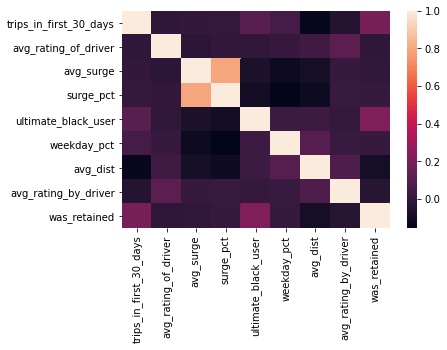

In [18]:
fig = plt.figure()
ax = plt.subplot()
corr = df.corr()
ax = sns.heatmap(corr)
plt.show()

In [19]:
corr['was_retained'].sort_values(ascending=False)

was_retained              1.000000
ultimate_black_user       0.217365
trips_in_first_30_days    0.198816
surge_pct                 0.011126
weekday_pct               0.010423
avg_surge                -0.004185
avg_rating_of_driver     -0.011829
avg_rating_by_driver     -0.034720
avg_dist                 -0.089498
Name: was_retained, dtype: float64

In [20]:
print(df['was_retained'].value_counts())

0    24410
1    17035
Name: was_retained, dtype: int64


It seems that the greatest correlations to retention are if the user was a black user, and the number of trips they took in the first 30 days. There also seem to be less retained drivers than those that left.

Now, we can one-hot encode our categorical variables (city and phone), drop some unnecessary colums, and convert our booleans to 0/1 for cleaner ML modeling.

In [21]:
df.drop(columns = ['signup_date','last_trip_date'],inplace=True)

In [22]:
df = pd.get_dummies(df)

In [23]:
df.ultimate_black_user = df.ultimate_black_user.replace([False,True],[0,1])

In [24]:
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,was_retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  41445 non-null  int64  
 1   avg_rating_of_driver    41445 non-null  float64
 2   avg_surge               41445 non-null  float64
 3   surge_pct               41445 non-null  float64
 4   ultimate_black_user     41445 non-null  int64  
 5   weekday_pct             41445 non-null  float64
 6   avg_dist                41445 non-null  float64
 7   avg_rating_by_driver    41445 non-null  float64
 8   was_retained            41445 non-null  int32  
 9   city_Astapor            41445 non-null  uint8  
 10  city_King's Landing     41445 non-null  uint8  
 11  city_Winterfell         41445 non-null  uint8  
 12  phone_Android           41445 non-null  uint8  
 13  phone_iPhone            41445 non-null  uint8  
dtypes: float64(6), int32(1), int64(2), uin

Now that our data has been processed, we can begin ML modeling and compare best results.

In [46]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import pickle
from joblib import dump, load

from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import  XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('was_retained', axis=1), 
                                                    df['was_retained'], test_size=0.25, 
                                                    random_state=141)

In [28]:
model_score = pd.DataFrame(columns=('r2', 'rmse'))

Let's start with Multinomial Naive Bayes.

In [31]:
%%time
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, y_train)

mnb_score = mnb.score(X_test, y_test)
mnb_predict = mnb.predict(X_test)

print('Multinomial Bayes R2:', mnb_score)
print('\n')

print("=== Classification Report ===")
print(classification_report(y_true=y_test, y_pred=mnb_predict))
print('\n')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_true=y_test, y_pred=mnb_predict))

Multinomial Bayes R2: 0.651322138583285


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.68      0.76      0.72      6128
           1       0.59      0.49      0.54      4234

    accuracy                           0.65     10362
   macro avg       0.64      0.63      0.63     10362
weighted avg       0.64      0.65      0.65     10362



=== Confusion Matrix ===
[[4670 1458]
 [2155 2079]]
Wall time: 160 ms


Let's try Decision Tree.

In [32]:
%%time
from sklearn.tree import DecisionTreeClassifier

dtc=DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train, y_train)

dtc_predict = dtc.predict(X_test)
dtc_score = dtc.score(X_test, y_test)

print('Decision Tree R2:', dtc_score)
print('\n')

print("=== Classification Report ===")
print(classification_report(y_true=y_test, y_pred=dtc_predict))
print('\n')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_true=y_test, y_pred=dtc_predict))

Decision Tree R2: 0.6959081258444316


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.75      0.74      6128
           1       0.63      0.62      0.62      4234

    accuracy                           0.70     10362
   macro avg       0.69      0.68      0.68     10362
weighted avg       0.70      0.70      0.70     10362



=== Confusion Matrix ===
[[4591 1537]
 [1614 2620]]
Wall time: 679 ms


Slightly better results, but let's see if kNN can do any better.

In [33]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(3)
knc.fit(X_train, y_train)

knc_predict = knc.predict(X_test)
knc_score = knc.score(X_test, y_test)

print('kNN R2:', knc_score)
print('\n')

print("=== Classification Report ===")
print(classification_report(y_true=y_test, y_pred=knc_predict))
print('\n')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_true=y_test, y_pred=knc_predict))

kNN R2: 0.7237984944991315


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6128
           1       0.67      0.65      0.66      4234

    accuracy                           0.72     10362
   macro avg       0.71      0.71      0.71     10362
weighted avg       0.72      0.72      0.72     10362



=== Confusion Matrix ===
[[4761 1367]
 [1495 2739]]
Wall time: 5.75 s


kNN is the best so far, but let's try some regression techniques now, starting with linear.

In [36]:
lrmodel = LinearRegression()
lrmodel.fit(X_train,y_train)

lr_predict = lrmodel.predict(X_test)

lr_r2 = metrics.r2_score(y_test, lr_predict)

print('Test R2 score is:', lr_r2)

Test R2 score is: 0.18931956999876298


We can finally try Logistic Regression to see if the fit improves, as our R2 is quite low.

In [44]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

logreg_predict = logreg_model.predict(X_test)
logreg_r2 = metrics.r2_score(y_test, logreg_predict)

print('Test R2 score is:', logreg_r2)

Test R2 score is: -0.23045483164387282


C:\Users\tuf04\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can now test Random Forest Classifier, as Linear and Logistic Regression did not work very well (likely because this is a classification problem).

In [45]:
ranForest_model = RandomForestClassifier(random_state=0)
ranForest_model.fit(X_train, y_train)

ranForest_predict = ranForest_model.predict(X_test)

ranForest_r2 = metrics.r2_score(y_test, ranForest_predict)

print('R2 Test:', ranForest_r2)

R2 Test: -0.03276734652095259


Let's try GBM.

In [47]:
gb_model = GradientBoostingClassifier(random_state=0)
gb_model.fit(X_train, y_train)

gb_predict = gb_model.predict(X_test)

gb_r2 = metrics.r2_score(y_test, gb_predict)

print('Gradient Boosting Test R2:', gb_r2)

Gradient Boosting Test R2: 0.08065335201421775


Now, let's try XGB.

In [48]:
xgb_model = XGBClassifier()

df_noDuplicate = df.loc[:,~df.columns.duplicated()]

X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(df_noDuplicate.drop('was_retained',axis=1), 
                                                    df['was_retained'], test_size=0.25, 
                                                    random_state=141)


xgb_model.fit(X_train_nd, y_train_nd)

xgb_predict = xgb_model.predict(X_test_nd)

xgb_r2 = metrics.r2_score(y_test_nd, xgb_predict)

print('The XGBoost r2 testing is:', xgb_r2)

C:\Users\tuf04\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The XGBoost r2 testing is: 0.09223504306182317


It seems that the kNN model has the best fit with an R2 of 0.724, which means we can accurately predict user retention at a rate of 72.4% using the kNN model.

It appears that importance is given to ratings, as well as whether the user is an Ultimate Black member or not. For future business improvements, these are the areas that should be focused on to increase driver retention.